In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image, ImageFilter
import os
from tqdm import tqdm
import seaborn as sns
sns.set_theme(palette=sns.color_palette('Set2'))

In [2]:
model = tf.keras.models.load_model('models//2024-04-09--18-41')

In [3]:
img_size = (92,70)
no_clusters = 2
no_images = len(os.listdir('pictures_rotated'))-12
pred_dict = {0:'paper', 1:'rock', 2:'scissors'}

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


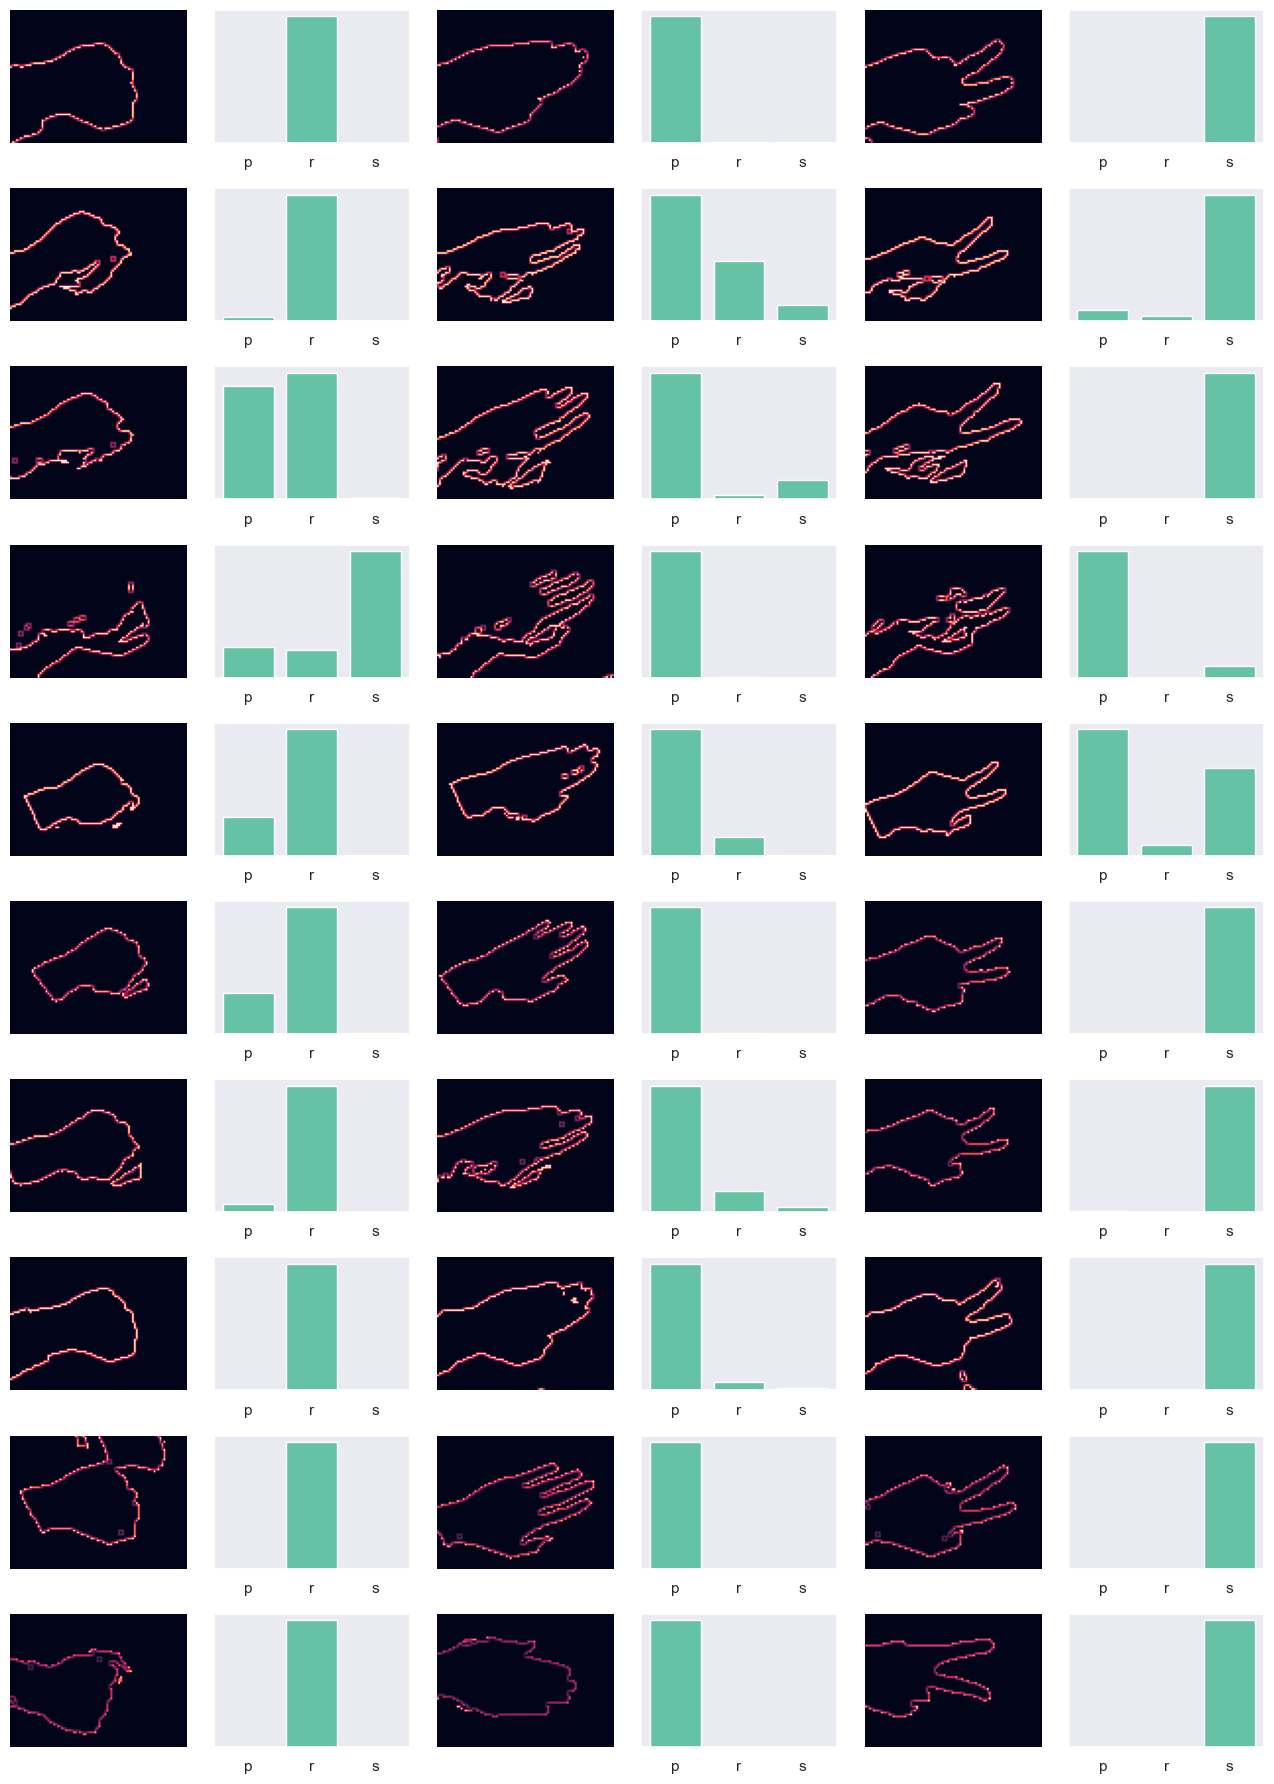

In [4]:
fig, axList = plt.subplots(nrows=no_images//3, ncols=6)
axList = axList.flatten()
fig.set_size_inches(13,no_images*.6)

for i in tqdm(range(no_images)):
    
    # load
    try:
        img = Image.open(f'pictures_rotated/{i+13}.jpg')
    except:
        img = Image.open(f'pictures_rotated/{i+13}.png')
    
    # resize
    img_resized = img.resize(img_size)
    
    # cast to array
    img_array = np.array(img_resized)
    
    # flatten for clustering
    img_flat = img_array.reshape(-1,3)
    
    # clustering
    kmeans = KMeans(n_clusters=no_clusters, random_state=0, n_init='auto').fit(img_flat)
    
    # generate clustered image
    for j in np.unique(kmeans.labels_):
        img_flat[kmeans.labels_==j,:] = kmeans.cluster_centers_[j]
    img_k = img_flat.reshape(img_array.shape)
    img_k = Image.fromarray(img_k)
    
    # convert to gray scale and fing edges
    img_e = img_k.convert('L')
    img_e = img_e.filter(ImageFilter.FIND_EDGES)
    
    # crop image to remove edges
    img_e = img_e.crop((1,1,img_size[0]-1,img_size[1]-1))
    
    # predict
    img_e_p = np.array(img_e)
    img_e_p = img_e_p.reshape(1, img_size[1]-2, img_size[0]-2, 1)
    img_e_p = img_e_p/255
    pred = model.predict(img_e_p, verbose=0)
    label_no = np.argmax(pred)
    label = pred_dict[label_no]
    
    # plot row of images
    ax = axList[i*2]
    ax.imshow(img_e)
    ax.axis('off')
    
    ax = axList[i*2+1]
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['p','r','s'])
    ax.set_yticks([])
    ax.grid(False)
    ax.bar(range(3),pred.reshape(3))

plt.tight_layout()
plt.savefig('predicting_clustered_edges_images.jpg')